In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder


# 1. Data Wrangling and Exploratory Data Analysis
First, train_2016_v2 and properties_2016 data files are loaded. Next, exclusive exploratory data analysis along with data warngling are performed in order to build a robust model with a high accuracy which predicts the log error of Zestimate.

In [3]:
train_df = pd.read_csv("./train_2016_v2.csv")
train_df.shape

(90275, 3)

In [4]:
train_df.head(n=10)

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02
5,11509835,-0.2705,2016-01-02
6,12286022,0.0440,2016-01-02
7,17177301,0.1638,2016-01-02
8,14739064,-0.0030,2016-01-02
9,14677559,0.0843,2016-01-03


In [5]:
prop= pd.read_csv("./properties_2016.csv",low_memory=False) 
prop.shape

(2985217, 58)

In [6]:
print (train_df['logerror'].min())
print (train_df['logerror'].max())


-4.605
4.737


In [7]:
sample= pd.read_csv('./sample_submission.csv')


# The Histogram of log-errors
The histogrem of log-errors shows that the distribution of log-errors is close to a normal distributions though there are some  outliers. At this point, I prefer not touching the outliers. 

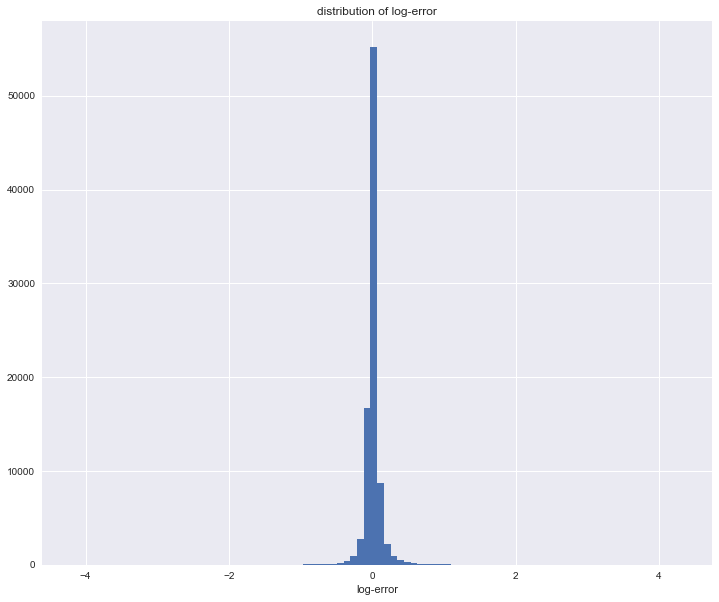

In [8]:
#Histogram of log-errors
plt.figure(figsize=(12,10))
plt.hist(train_df['logerror'], bins= 100)
plt.xlim((train_df['logerror'].min(),train_df['logerror'].max()))
plt.title('distribution of log-error')
plt.xlabel('log-error')
plt.show()


 # Transaction Percentage
 Next, I calculate a new variable named 'transaction' which shows how many times each parcel is sold. It is found that the percentage of properties sold:
 1. once is 99.86%
 2. twice is 0.14%
 3. more twice is almost 0%. 
 
The vast majority of the houses sold once during the period that the data was collected. 

In [9]:
#Transaction data shows how many times each parcel were sold. 
#size() includes NaN values
transaction = pd.DataFrame({'count' : train_df.groupby("parcelid").size()}).reset_index()



In [10]:
# Looking for nulls
print(train_df['parcelid'].isnull().sum())

0


In [11]:
print ("The percentage of properties sold:")
print( "once = "
        + str(transaction[transaction['count']==1].size / transaction.size * 100) + "%" )
print ("twice = "
        + str(transaction[transaction['count']==2].size / transaction.size * 100) + "%" )
print ("more twice = "
        + str(transaction[transaction['count']>2].size / transaction.size * 100) + "%" )


The percentage of properties sold:
once = 99.8624514698%
twice = 0.136439267887%
more twice = 0.00110926234054%


In [12]:
(train_df['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

# Monthly Transactions
There are more transactions during summer months, between May and October. Starting from October till the end of year,
the number of transactions drops significantly compared to the previous months. However, the reason for that drop in the graph is the dataset contains all transactions before October 15th 2016 and some transactions after that date. 

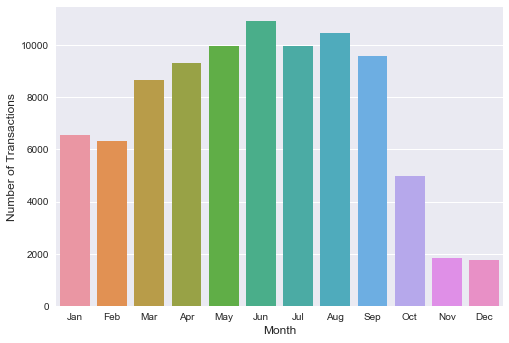

In [13]:
train_df['transactiondate'] = pd.to_datetime(train_df['transactiondate'])
train_df['transactionMonth'] = train_df['transactiondate'].dt.strftime('%b')
transaction_month = train_df['transactionMonth'].value_counts()
sns.barplot(transaction_month.index, transaction_month.values, order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug',
                                              'Sep','Oct','Nov','Dec'])
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.show()


# Missing Values in Features
properties_2016 data set looks having too many missing values. Next, we investigate which variables have the highest missing values. 
From the histogram below, it can be seen that there are many variables with high missing value percentage i.e. higher than 80%. 
I prefer dropping most of the features which have too many missing values (>80%)- unless it represents a unique property of the house like the number of pools or fireplaces.

In [14]:
##Properties data set looks having too many missing values. Let's investigate which variables have the highest missing values.
#nans_df = prop.drop('parcelid', axis=1).isnull().sum()
nans_df = prop.isnull().sum()
nans_df.sort_values(ascending=True, inplace=True)
nans_df = nans_df / prop.shape[0]
#nans_df.sort_values(ascending = False).head(n=15)
nans_df[nans_df>0.8].sort_values(ascending = False)
##There are many variables with large missing value percentage

storytypeid                 0.999456
basementsqft                0.999455
yardbuildingsqft26          0.999113
fireplaceflag               0.998270
architecturalstyletypeid    0.997970
typeconstructiontypeid      0.997740
finishedsquarefeet13        0.997430
buildingclasstypeid         0.995769
decktypeid                  0.994273
finishedsquarefeet6         0.992630
poolsizesum                 0.990634
pooltypeid2                 0.989255
pooltypeid10                0.987626
taxdelinquencyflag          0.981086
taxdelinquencyyear          0.981085
hashottuborspa              0.976881
yardbuildingsqft17          0.973082
finishedsquarefeet15        0.936086
finishedsquarefeet50        0.932093
finishedfloor1squarefeet    0.932093
threequarterbathnbr         0.895609
fireplacecnt                0.895272
pooltypeid7                 0.837379
poolcnt                     0.826634
dtype: float64

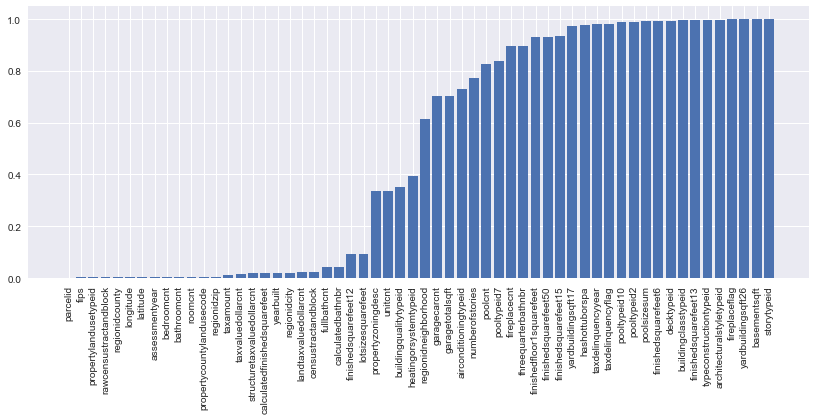

In [15]:
plt.figure(figsize=(14, 5))
plt.bar(range(len(nans_df.index)), nans_df.values)
plt.xticks(range(len(nans_df.index)), nans_df.index.values, rotation='vertical')
plt.show()

In [16]:
##Variables which have too many missing values (>80%) are dropped since they will not provide much information for the analysis. 
zillow= prop.drop(['storytypeid', 'basementsqft', 'yardbuildingsqft26', 'fireplaceflag', 'architecturalstyletypeid', 
            'typeconstructiontypeid', 'finishedsquarefeet13', 'buildingclasstypeid',
            'decktypeid', 'finishedsquarefeet6', 'poolsizesum', 'pooltypeid2', 'pooltypeid10', 'taxdelinquencyflag',
            'taxdelinquencyyear', 'hashottuborspa', 'yardbuildingsqft17', 'finishedsquarefeet15', 'finishedsquarefeet50',
            'finishedfloor1squarefeet', 'threequarterbathnbr', 'pooltypeid7'], axis=1)

In [17]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 36 columns):
parcelid                        int64
airconditioningtypeid           float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
heatingorsystemtypeid           float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolcnt                         float64
propertycountylandusecode       object
propertylandusetypeid           float64
propertyzoningdesc              object
rawcensustractandblock          float64
regionidcit

# More data wrangling 
Examining the description of the features, I see that there are similar/same features in the data. For example, the feature 'bathroomcnt' and 'calculatedbathnbr' are equal. Likewise, it can be seen in the data dictionary, the definition of 'rawcensustractandblock' and 'censustractandblock' are the same,eg.census tract and block ID combined although the columns for the corresponding features are not exactly equal. The repeated features create collinearity and complexity in modeling, thus I elimate repeated features. 

I also elimate the object type 2 features, i.e.'propertyzoningdesc', 'propertycountylandusecode', since these features require more processing and make model building and interpretation more complex.

Lastly, the categorical feature 'transactionMonth' is encoded before modeling. 

In [18]:
##It looks like there are repetations in features, eg. bathroomcnt and calculatedbathnbr are the same. 
(zillow['bathroomcnt']-zillow['calculatedbathnbr']).sum()

0.0

In [19]:
zillow= zillow.drop('calculatedbathnbr',axis =1)

In [20]:
(zillow[['rawcensustractandblock','censustractandblock']]).head()

,rawcensustractandblock,censustractandblock
0,6.037800e+07,NaN
1,6.037800e+07,NaN
2,6.037703e+07,NaN
3,6.037141e+07,NaN
4,6.037123e+07,NaN


In [21]:
zillow['rawcensustractandblock'].isnull().sum()

11437

In [22]:
##In the data dictionary, the definition of 'rawcensustractandblock' and 'censustractandblock' are the same,eg.census tract and
##block ID combined. So, I drop one of them. 
zillow = zillow.drop('censustractandblock',axis = 1)

In [23]:
(zillow[['propertyzoningdesc', 'propertycountylandusecode']]).head()

,propertyzoningdesc,propertycountylandusecode
0,NaN,010D
1,LCA11*,0109
2,LAC2,1200
3,LAC2,1200
4,LAM1,1210


In [24]:
zillow = zillow.drop(['propertyzoningdesc', 'propertycountylandusecode'], axis =1)#object features(like id)

In [25]:
(zillow[['calculatedfinishedsquarefeet','finishedsquarefeet12']]).head()

,calculatedfinishedsquarefeet,finishedsquarefeet12
0,NaN,NaN
1,NaN,NaN
2,73026.0,NaN
3,5068.0,NaN
4,1776.0,NaN


In [26]:
(zillow['calculatedfinishedsquarefeet']-zillow['finishedsquarefeet12']).sum()

0.0

In [27]:
zillow = zillow.drop(['finishedsquarefeet12'] ,axis=1)

In [28]:

for l in train_df[['transactionMonth']]:
                #,'propertycountylandusecode', 'propertyzoningdesc']]:
    label = LabelEncoder()
    label.fit(list(train_df[l].values))
    train_df[l] = label.transform(list(train_df[l].values))

# Preparing the data set
Following, the data sets are merged to prepare the set for analysis. In addition, NaN values replaced with -1 since many ML algorithms like Random Forest Regressor do not handle missing values and their performances get worse when adding 
features with increasing percentages of NaN's and one of the suggested solution is to replace NaNn's with a single out-of-range value like -1.0. 

In [29]:
#Merge train and zillow data set
train = pd.merge(train_df, zillow, on='parcelid', how='left')
train.head()

,parcelid,logerror,transactiondate,transactionMonth,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,...,regionidzip,roomcnt,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount
0,11016594,0.0276,2016-01-01,4,1.0,2.0,3.0,4.0,1684.0,6037.0,...,96370.0,0.0,1.0,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.88
1,14366692,-0.1684,2016-01-01,4,NaN,3.5,4.0,NaN,2263.0,6059.0,...,96962.0,0.0,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.02
2,12098116,-0.0040,2016-01-01,4,1.0,3.0,2.0,4.0,2217.0,6037.0,...,96293.0,0.0,1.0,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.48
3,12643413,0.0218,2016-01-02,4,1.0,2.0,2.0,4.0,839.0,6037.0,...,96222.0,0.0,1.0,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.74
4,14432541,-0.0050,2016-01-02,4,NaN,2.5,4.0,NaN,2283.0,6059.0,...,96961.0,8.0,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96


In [30]:
test = pd.merge(sample, zillow, how='left', left_on='ParcelId', right_on='parcelid')
test = test.drop('ParcelId',axis=1)
test.head()

,201610,201611,201612,201710,201711,201712,parcelid,airconditioningtypeid,bathroomcnt,bedroomcnt,...,regionidzip,roomcnt,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount
0,0,0,0,0,0,0,10754147,NaN,0.0,0.0,...,96337.0,0.0,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN
1,0,0,0,0,0,0,10759547,NaN,0.0,0.0,...,96337.0,0.0,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN
2,0,0,0,0,0,0,10843547,NaN,0.0,0.0,...,96095.0,0.0,2.0,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37
3,0,0,0,0,0,0,10859147,NaN,0.0,0.0,...,96424.0,0.0,NaN,1948.0,1.0,571346.0,1156834.0,2015.0,585488.0,14557.57
4,0,0,0,0,0,0,10879947,NaN,0.0,0.0,...,96450.0,0.0,1.0,1947.0,NaN,193796.0,433491.0,2015.0,239695.0,5725.17


In [31]:
#Fill NaN values in -1 before building models
for x in train.columns:
    train[x] = train[x].fillna(-1)

In [32]:
for x in test.columns:
    test[x] = test[x].fillna(-1)

# Correlation Between Features
After data wrangling, there are still highly correlated features but I decide to keep those since they should not affect the performance of predictions, actually they might be useful. In addition, models I will use can handle these features.



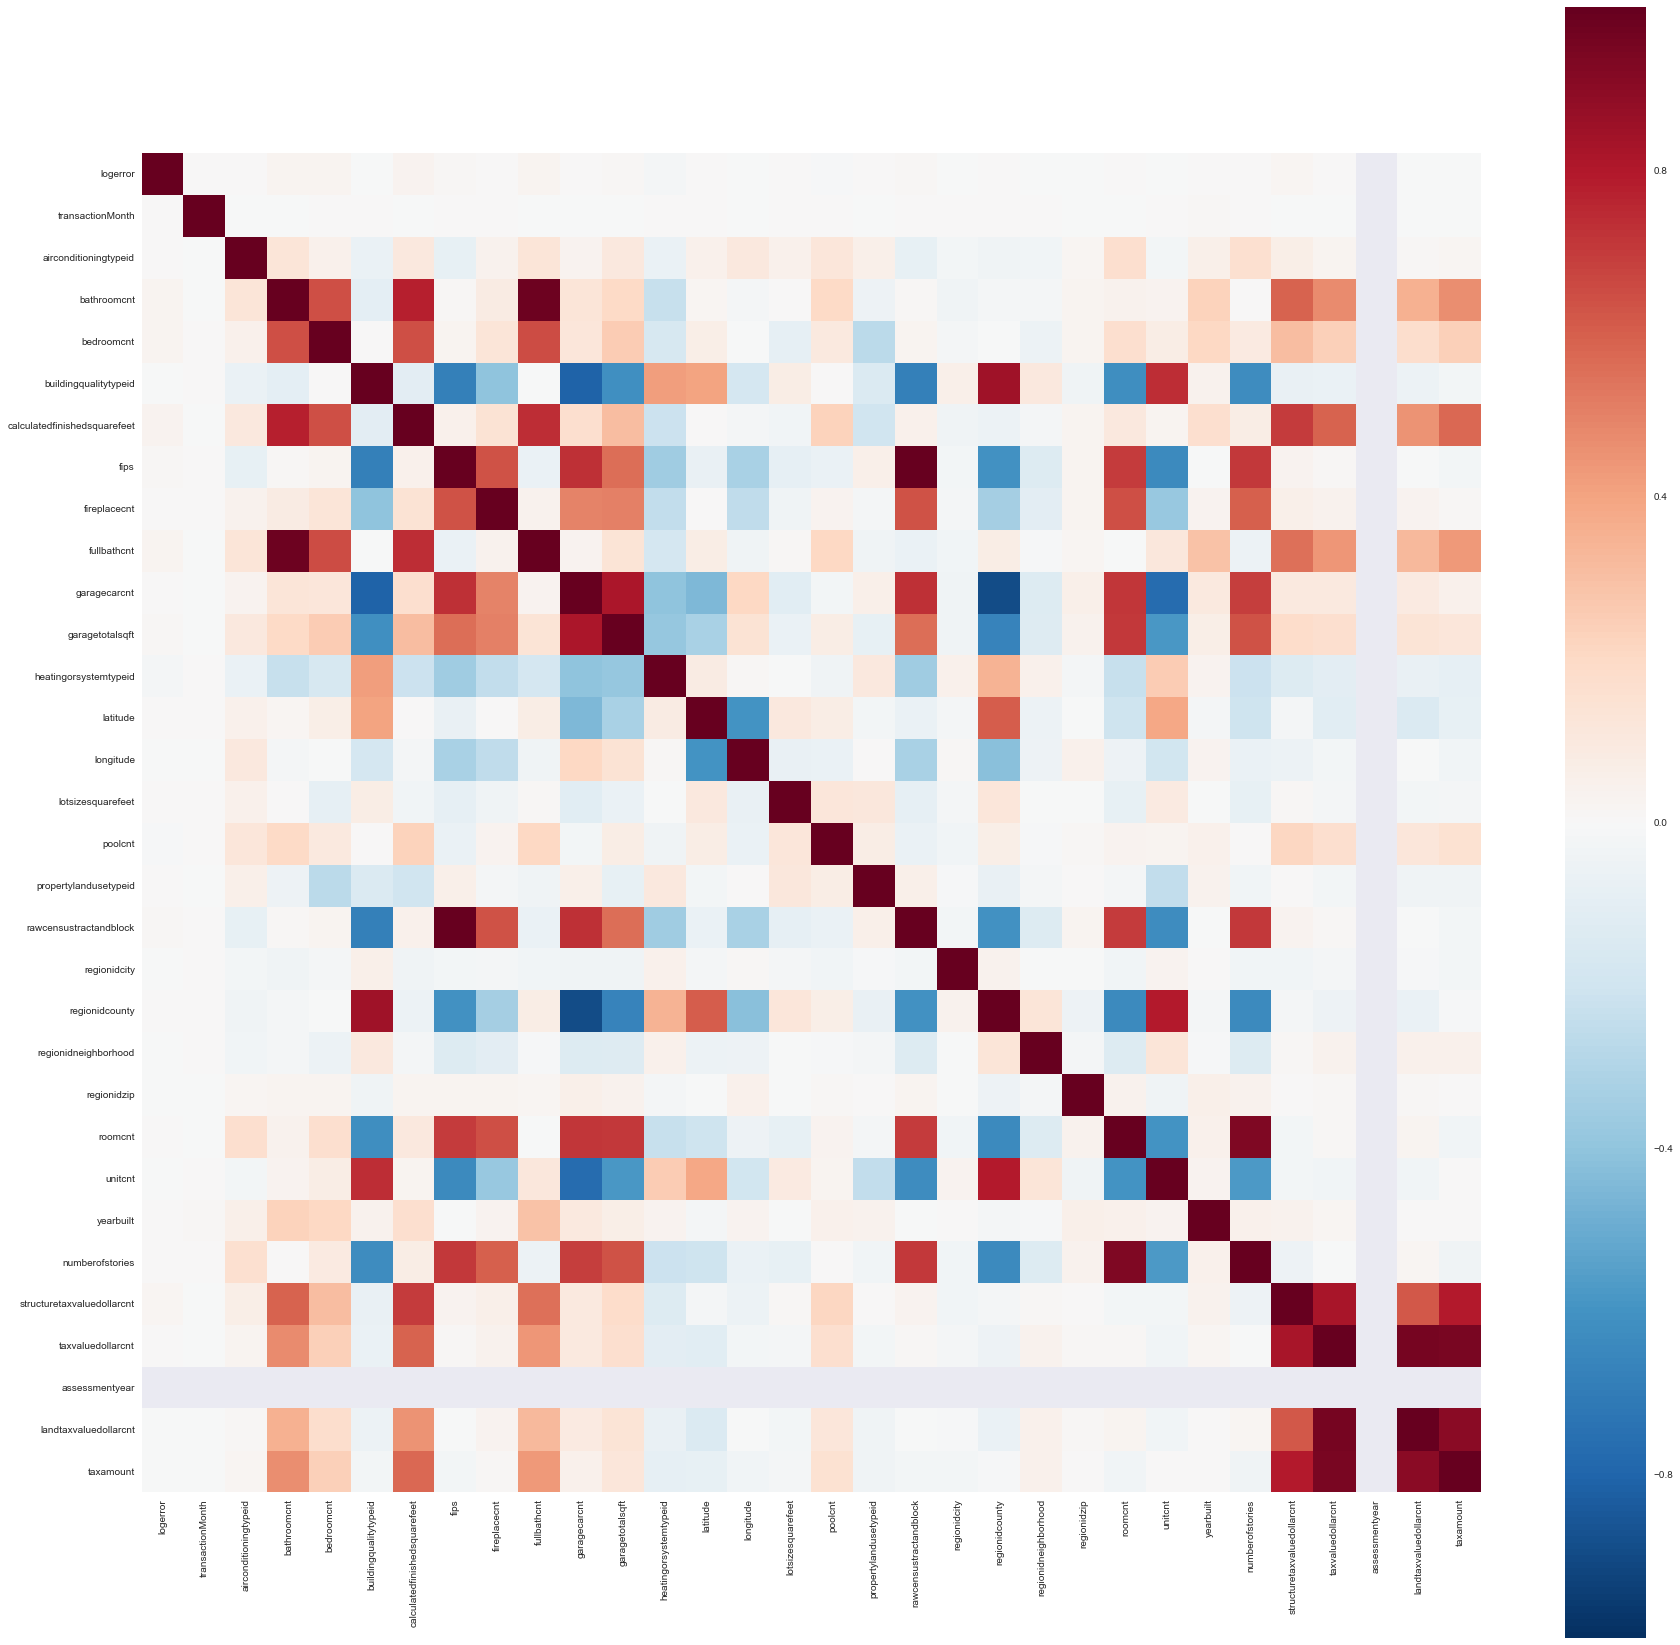

In [33]:
correlation = train.select_dtypes(include = ['float64','int64']).iloc[:,1:].corr()
plt.figure(figsize=(30, 30))
sns.heatmap(correlation,vmax=1,square= True)

# Feature Selection
Before prediction, I use sklearn.ensemble Random Forest Regressor Algorithm to select most relevant features in model construction. The aim of this section is to choose features that may not contribute to the better accuracy of the a predictive model. 

Feature selection also reduces the complexity of the model which yields a simpler model to explain. 

In [34]:
X_train = train.drop(['parcelid', 'logerror', 'transactiondate','transactionMonth'], axis=1).as_matrix()
y_train = train['logerror'].values
names = train.drop(['parcelid', 'logerror', 'transactiondate','transactionMonth'], axis=1).columns


In [35]:
X_test = test.drop(['parcelid'],axis=1,inplace=False)


In [36]:
X_test= X_test[names]

# Random Forest

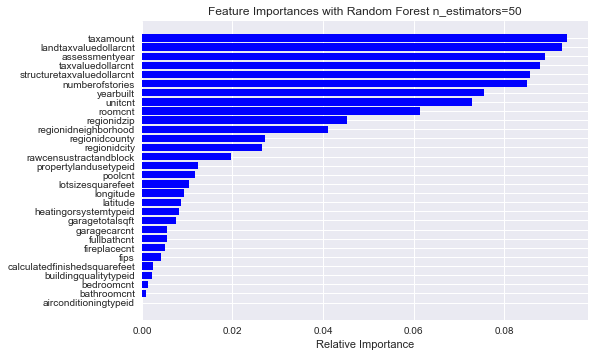

In [37]:
#random forest
rf1 = RandomForestRegressor(n_estimators=50, max_features=None)
rf1.fit(X_train, y_train)
importances1 = rf1.feature_importances_
indices1 = np.argsort(importances1)

plt.title('Feature Importances with Random Forest n_estimators=50')
plt.barh(range(len(indices1)), importances1[indices1], color='b', align='center')
plt.yticks(range(len(indices1)), names) 
plt.xlabel('Relative Importance')
plt.show()

In [38]:
from sklearn.model_selection import GridSearchCV
#set the paramater dict to try
parameters = {
                 'n_estimators': [10, 50, 100],
                 'max_depth': [5, 10,15]
             }
             
grid = GridSearchCV(rf1, parameters)

grid.fit(X_train, y_train)

print(grid.best_score_)
print(grid.best_params_)


0.00537487111881
{'max_depth': 5, 'n_estimators': 50}


  param_n_estimators  mean_test_score  std_test_score
0                 10         0.001374        0.004582
1                 50         0.005375        0.002952
2                100         0.004089        0.003454
3                 10        -0.008327        0.001718
4                 50        -0.000629        0.002696
5                100         0.003333        0.002585
6                 10        -0.028738        0.008356
7                 50        -0.006635        0.003799
8                100        -0.005418        0.004553


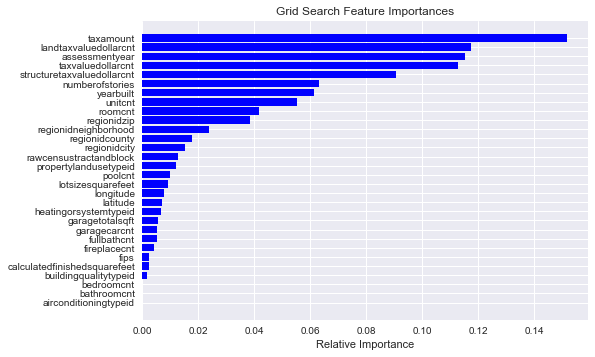

In [39]:
cross_validation = pd.DataFrame(grid.cv_results_)
print(cross_validation[["param_n_estimators","mean_test_score","std_test_score"]])

importance_grid = grid.best_estimator_.feature_importances_
indices_grid = np.argsort(importance_grid)

plt.title('Grid Search Feature Importances')
plt.barh(range(len(indices_grid)), importance_grid[indices_grid], color='b', align='center')
plt.yticks(range(len(indices_grid)), names) 
plt.xlabel('Relative Importance')
plt.show()


In [40]:
y_test_columns = ['201610','201611','201612','201710','201711','201712']

for i in y_test_columns:
    test[i] = y_test
    
test.to_csv('grid_estimate.csv', index=False)

NameError: name 'y_test' is not defined